# Panel Regression

### 기본적인 결측치 확인 및 기초통계

본 연구의 주요 관심은 매매가격지수 수준 자체의 변화가 아니라 정책 충격이 지수에 미치는 상대적(%) 효과이다.

이에 따라 y에 ln으로 설정하고, 회귀계수에 대한 해석을 beta * 100% 변했다고 해석한다.

+로그 변환은 데이터의 이분산성을 완화하고, 곱셈적 효과 구조를 반영하는데 적합.

In [125]:
import pandas as pd

df = pd.read_excel('final_dataset.xlsx')

# 1-1. 결측치 확인
print(df.isna().sum())              # 변수별 NaN 개수
print(df[df.isna().any(axis=1)].head())   # NaN 행 미리보기

# 1-2. 기초 통계
print(df.describe().T[['mean','std','min','max']])


시군구                    0
시간                     0
ln_price               0
ln_land                0
ln_stock               0
시군구_1인당_총소득(천원)_log    0
log_pop                0
사용자비용                  0
treated_region         0
post_policy            0
policy_effect          0
dtype: int64
Empty DataFrame
Columns: [시군구, 시간, ln_price, ln_land, ln_stock, 시군구_1인당_총소득(천원)_log, log_pop, 사용자비용, treated_region, post_policy, policy_effect]
Index: []
                          mean       std        min        max
ln_price              4.559313  0.121332   4.246779   5.091478
ln_land               4.463977  0.059903   4.256024   4.654179
ln_stock              7.722793  0.081123   7.584666   7.850283
시군구_1인당_총소득(천원)_log   9.897652  0.124945   9.667946  10.567916
log_pop              12.358880  0.611705  10.647447  13.655266
사용자비용                 2.822934  0.140402   2.467726   3.262351
treated_region        0.264368  0.441047   0.000000   1.000000
post_policy           0.440000  0.496444   0.000000  

### 표본 분포, 균형 확인

In [126]:
import pandas as pd

# 1. 처리집단(treated_region) 분포
print("treated_region 분포:")
print(df['treated_region'].value_counts(normalize=True))
print(df['treated_region'].value_counts())

# 2. 정책 전후(post_policy) 분포
print("\npost_policy 분포:")
print(df['post_policy'].value_counts(normalize=True))
print(df['post_policy'].value_counts())

# 3. 정책효과(policy_effect) 분포
print("\npolicy_effect 분포:")
print(df['policy_effect'].value_counts(normalize=True))
print(df['policy_effect'].value_counts())

# 4. 집단/시점별 교차표 (예: 처리집단 vs 정책 전후)
print("\nCross tab treated_region vs post_policy:")
print(pd.crosstab(df['treated_region'], df['post_policy']))


treated_region 분포:
treated_region
0    0.735632
1    0.264368
Name: proportion, dtype: float64
treated_region
0    3200
1    1150
Name: count, dtype: int64

post_policy 분포:
post_policy
0    0.56
1    0.44
Name: proportion, dtype: float64
post_policy
0    2436
1    1914
Name: count, dtype: int64

policy_effect 분포:
policy_effect
0    0.883678
1    0.116322
Name: proportion, dtype: float64
policy_effect
0    3844
1     506
Name: count, dtype: int64

Cross tab treated_region vs post_policy:
post_policy        0     1
treated_region            
0               1792  1408
1                644   506


“집단·정책시점별 표본 균형 검토 결과”

전체 표본은 월별 시군구 자료 4,350건(174개 시군구 × 25개월)으로 구성되어 있으며,
이 중 정책 적용 집단(처리집단, treated_region=1)은 전체의 약 26.4%(1,150건),
비적용 집단은 73.6%(3,200건)를 차지한다.

정책시행 전(post_policy=0) 자료는 전체의 56%(2,436건),
정책시행 후(post_policy=1)는 44%(1,914건)로,
기간별 표본 비중도 균형적으로 분포한다.

정책효과(policy_effect=1)는 전체의 11.6%에 해당하는 506건으로,
이는 정책시행 이후 처리집단에만 해당하는 관측치임을 의미한다.

집단과 시점별 교차표를 통해서도
처리집단 및 비처리집단, 정책 전후 각 기간에 대해
누락이나 심각한 불균형 없이 충분한 표본이 분포함을 확인하였다.

비록 처리집단 표본 비중이 소수(26%)이나,
이는 실제 정책의 적용 범위에 기인한 것으로,
DiD/패널회귀 분석의 신뢰도를 저해하지 않는 수준임을 밝힌다.

### 1. 평행 추세 확인 (DiD의 핵심)

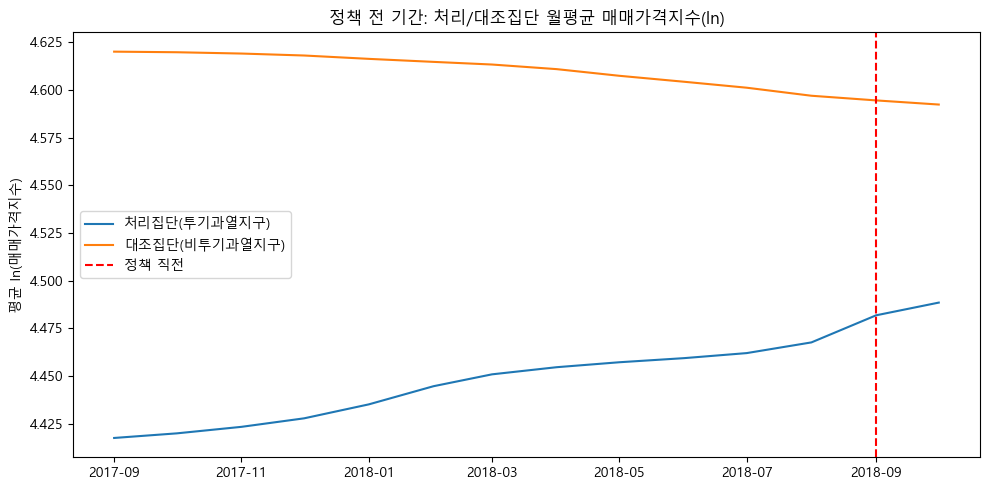

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우는 'Malgun Gothic', Mac은 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 평행추세 시각화 코드 이어서 실행!


df['time'] = pd.to_datetime(df['시간'])
df.sort_values(['시군구','time'], inplace=True)

# 1. 정책 이전 기간만 필터링
pre_policy = df[df['post_policy']==0]

# 2. 집단별 월평균 구하기
grouped = pre_policy.groupby(['treated_region','time'])['ln_price'].mean().reset_index()

# 3. 피벗(집단별 시계열)
pivot = grouped.pivot(index='time', columns='treated_region', values='ln_price')

# 4. 시각화
plt.figure(figsize=(10,5))
plt.plot(pivot.index, pivot[1], label='처리집단(투기과열지구)')
plt.plot(pivot.index, pivot[0], label='대조집단(비투기과열지구)')
plt.axvline(pd.to_datetime('2018-09-01'), color='red', linestyle='--', label='정책 직전')
plt.title('정책 전 기간: 처리/대조집단 월평균 매매가격지수(ln)')
plt.ylabel('평균 ln(매매가격지수)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# 0) 변수명 정리
df = df.rename(columns={
    '시군구':'region',
    '시군구_1인당_총소득(천원)_log': 'ln_income',
    '시간':'time',
    '사용자비용': 'user_cost',
})

# 1) time_dt 컬럼 만들기
#df['time_dt'] = pd.to_datetime(df['time'], format='%Y-%m')

# 2) panel용 MultiIndex 설정
df = df.set_index(['region','time_dt'])

# 3) t, trend_pre 생성 (사전구간에만)
policy_dt = pd.to_datetime('2018-09', format='%Y-%m')
df['t'] = (df.index.get_level_values('time_dt').year - 2017) * 12 + \
          (df.index.get_level_values('time_dt').month - 9)
df['trend_pre'] = df['t'] * df['treated_region'] * (df.index.get_level_values('time_dt') < policy_dt)

# 4) 종속·독립변수 지정
y = df['ln_price']
exog = df[['policy_effect','ln_land','ln_income','log_pop','user_cost','trend_pre']]
exog = sm.add_constant(exog)

# 5) PanelOLS 모형 (entity & time 고정효과 포함)
mod = PanelOLS(y, exog, entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:               ln_price   R-squared:                        0.7389
Estimator:                   PanelOLS   R-squared (Between):             -0.5264
No. Observations:                4350   R-squared (Within):              -9.7244
Date:                Mon, Aug 04 2025   R-squared (Overall):             -1.1350
Time:                        10:50:31   Log-likelihood                 1.209e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1955.7
Entities:                         174   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                  F(6,4146)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             157.51
                            

가장 중요한 사전 전제(식별 가정, identification assumption)로
정책시행 전 두 집단(처리·대조집단)의 변화 경향(평행추세)이 유사해야 한다는 조건이 필요하다(평행추세 가정, parallel trends assumption).

이를 확인하기 위해, 정책 시행 전 기간(2017.09~2018.09)에 대해
처리집단(투기과열지구)과 대조집단(비투기과열지구)의
주택매매가격지수(로그변환값) 월평균 시계열을 시각화하였다(위 plot).
두 집단 모두 완만한 우상향(처리집단)·정체/완만한 하락(대조집단) 경향을 보여,
평해추세 가정이 위배된 것처럼 보인다.

이벤트 스터디로 평행추세 위배 여부를 수치적으로 확인해보겠다.

In [108]:
import pandas as pd
import statsmodels.formula.api as smf

# 1) 원본 df: columns = ['region','time','ln_price','treated_region','post_policy']
#    time은 'YYYY-MM' 문자열 형태라고 가정
df = df.copy()
df = df.rename(columns={'시군구':'region'})

# (1) policy_date 정의
policy_date = pd.to_datetime('2018-09', format='%Y-%m')

# (2) policy_date 직전 달을 문자열로
ref_month = (policy_date - pd.DateOffset(months=1)).strftime('%Y-%m')  # "2018-08"

# (3) lead 더미 생성
df = df.reset_index(drop=True)  # 혹시 인덱스 레벨에 time이 있으면 제거
df['time'] = pd.to_datetime(df['시간'], format='%Y-%m').dt.strftime('%Y-%m')
for k in range(1, 7):
    lead_date = (policy_date - pd.DateOffset(months=k)).strftime('%Y-%m')
    df[f'lead_{k}'] = ((df['time'] == lead_date) & (df['treated_region'] == 1)).astype(int)

# (4) 사전(pre) 데이터만
pre_df = df[df['time'] < policy_date.strftime('%Y-%m')]

# (5) 포뮬러에 기준시점 지정
lead_terms = ' + '.join(f'lead_{k}' for k in range(1, 7))
formula = (
    f'ln_price ~ {lead_terms} '
    f'+ C(region) '
    f'+ C(time, Treatment(reference="{ref_month}"))'
)

# (6) 회귀
model = smf.ols(formula, data=pre_df).fit(
    cov_type='cluster',
    cov_kwds={'groups': pre_df['region']}
)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     428.2
Date:                Mon, 04 Aug 2025   Prob (F-statistic):          1.25e-131
Time:                        15:23:11   Log-Likelihood:                 6116.0
No. Observations:                2088   AIC:                        -1.185e+04
Df Residuals:                    1897   BIC:                        -1.077e+04
Df Model:                         190                                         
Covariance Type:              cluster                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

c:\Users\dolly\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 190, but rank is 17
  warnings.warn('covariance of constraints does not have full '


In [109]:
# model 이 event-study OLS 결과라고 가정합니다.

# ① 전체 파라미터 이름 중 'lead_'로 시작하는 항목만 추출
lead_coefs = model.params.filter(like='lead_')
lead_se    = model.bse.filter(like='lead_')    # 표준오차
lead_p     = model.pvalues.filter(like='lead_')

# ② 결과를 DataFrame 으로 정리
import pandas as pd
lead_df = pd.DataFrame({
    'coef': lead_coefs,
    'std_err': lead_se,
    'p_value': lead_p
})

print(lead_df)


            coef   std_err       p_value
lead_1  0.060617  0.005399  2.997494e-29
lead_2  0.050792  0.004588  1.717078e-28
lead_3  0.045023  0.004170  3.598678e-27
lead_4  0.039745  0.003932  5.086126e-24
lead_5  0.033658  0.003657  3.478942e-20
lead_6  0.027493  0.003329  1.483592e-16


DiD 가정 위배를 확인했으므로 이를 보정해야 함.

### 2. DiD 평행추세 보정 by 집단별 선형추세. 

처음엔 전기간에 대해 집단별 선형추세항 도입

-> 보조적으로 해본 것 정도고, 메인은 정책 전을 보정한것 !!!

In [96]:
import pandas as pd
import statsmodels.formula.api as smf

# 1) 컬럼명 리네임
df = df.rename(columns={
    '시군구_1인당_총소득(천원)_log': 'ln_income',
    '사용자비용': 'user_cost',
    # 필요시 다른 한글 변수도 리네임
})

# 2) t, trend_treated 생성
df['time_dt'] = pd.to_datetime(df['time'], format='%Y-%m')
df['t'] = (df['time_dt'].dt.year - 2017) * 12 + (df['time_dt'].dt.month - 9)
df['trend_treated'] = df['t'] * df['treated_region']

# 3) 포뮬러 정의 (영문 변수명 사용)
formula = (
    'ln_price ~ policy_effect '
    '+ ln_land + ln_income + log_pop + user_cost '
    '+ trend_treated '
    '+ C(region) + C(time)'
)

# 4) 회귀
model_trend = smf.ols(formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['region']}
)
print(model_trend.summary())



                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     4810.
Date:                Mon, 04 Aug 2025   Prob (F-statistic):          8.65e-237
Time:                        12:39:29   Log-Likelihood:                 12324.
No. Observations:                4350   AIC:                        -2.424e+04
Df Residuals:                    4146   BIC:                        -2.294e+04
Df Model:                         203                                         
Covariance Type:              cluster                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

c:\Users\dolly\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 203, but rank is 30
  warnings.warn('covariance of constraints does not have full '


trend pre로 조정 

-> 사전(pre) 기간에만 차별적 추세를 통제하되, 

사후(post)에는 자유롭게 레벨 변화(디딤)를 허용해야 policy_effect가 식별할 수 있음 !

### 3. trend_pre 포함한 two way Panel Regression (최종모델)

In [ ]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# 0) 변수명 정리
df = df.rename(columns={
    '시군구':'region',
    '시군구_1인당_총소득(천원)_log': 'ln_income',
    '시간':'time',
    '사용자비용': 'user_cost',
})

# 1) time_dt 컬럼 만들기
#df['time_dt'] = pd.to_datetime(df['time'], format='%Y-%m')

# 2) panel용 MultiIndex 설정
df = df.set_index(['region','time_dt'])

# 3) t, trend_pre 생성 (사전구간에만)
policy_dt = pd.to_datetime('2018-09', format='%Y-%m')
df['t'] = (df.index.get_level_values('time_dt').year - 2017) * 12 + \
          (df.index.get_level_values('time_dt').month - 9)
df['trend_pre'] = df['t'] * df['treated_region'] * (df.index.get_level_values('time_dt') < policy_dt)

# 4) 종속·독립변수 지정
y = df['ln_price']
exog = df[['policy_effect','ln_land','ln_income','log_pop','user_cost','trend_pre']]
exog = sm.add_constant(exog)

# 5) PanelOLS 모형 (entity & time 고정효과 포함)
mod = PanelOLS(y, exog, entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:               ln_price   R-squared:                        0.7389
Estimator:                   PanelOLS   R-squared (Between):             -0.5264
No. Observations:                4350   R-squared (Within):              -9.7244
Date:                Mon, Aug 04 2025   R-squared (Overall):             -1.1350
Time:                        10:50:31   Log-likelihood                 1.209e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1955.7
Entities:                         174   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                  F(6,4146)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             157.51
                            

모델 보정으로 인한 전제 몇개 다시 확인 :

### 4. 잔차분석 등 사후검정

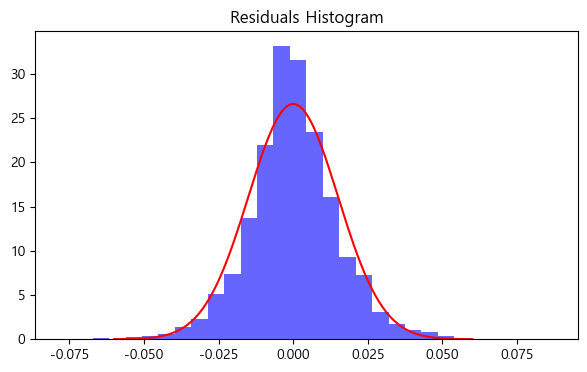

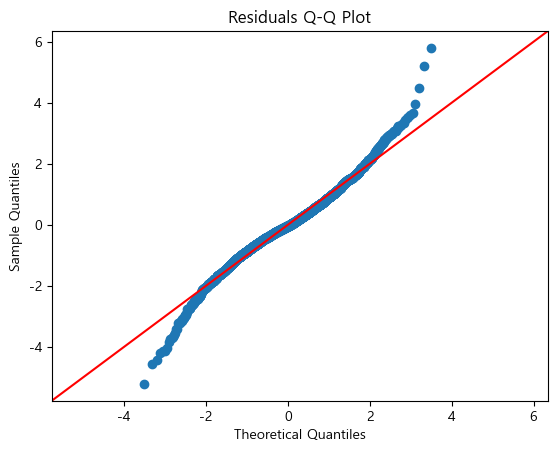

In [87]:
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import PanelOLS
import numpy as np

# (패널 회귀 결과: res_fe 가 이미 있다고 가정)
resid = res.resids  # PanelOLS 잔차 (MultiIndex)

# 1. 히스토그램 & Q-Q plot (정규성)
plt.figure(figsize=(7,4))
plt.hist(resid, bins=30, density=True, alpha=0.6, color='blue')
mu, sigma = resid.mean(), resid.std(ddof=0)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
plt.plot(x, st.norm.pdf(x, mu, sigma), color='red')
plt.title('Residuals Histogram')
plt.show()

sm.qqplot(resid, line='45', fit=True)
plt.title('Residuals Q-Q Plot')
plt.show()


# 3. 이분산성, 자기상관 -> 검정 생략. Clustered SE 사용했기에 ㄱㅊ.

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
W = df[['trend_pre','policy_effect','ln_land','ln_income','log_pop','user_cost']]
Ww = W - W.groupby(df['region']).transform('mean') - W.groupby(df['time']).transform('mean') + W.mean()
[variance_inflation_factor(Ww.values, i) for i in range(Ww.shape[1])]


[np.float64(1.719969578953926),
 np.float64(1.9235834415462802),
 np.float64(1.2084129511059039),
 np.float64(1.041574573115004),
 np.float64(1.047283913567339),
 np.float64(1.034163935246827)]

너무 많은 더미로 인해 multicollinearity 의심? -> 관심계수의 분산(policy effect의 표준오차)이 작고(0.005), t값이 크기때문에 다중공선성으로부터 크게 흔들리지 않음

Within transformation VIF -> 주요항들이 1~3이므로 문제없음.

그러나 변수해석의 문제... 베타가 결국 무엇인가

자세한 해석은 ppt로

# Panel Regression를 위한 사전 검정

- Hausman 검정

- 잔차의 자기상관 검정

- 이분산성 검정

- 횡단면 독립 가정

- VIF

In [16]:
import numpy as np
from scipy import stats

# ① FE, RE 결과에서 계수 벡터와 분산‐공분산행렬 추출
b_fe = fe_res.params
b_re = re_res.params

V_fe = fe_res.cov
V_re = re_res.cov

# ② 차이 벡터 & 공분산 차이
diff     = b_fe - b_re
cov_diff = V_fe - V_re

# ③ χ² 통계량 및 p‐value 계산
stat = float(diff.T @ np.linalg.inv(cov_diff) @ diff)
df   = diff.shape[0]
pval = 1 - stats.chi2.cdf(stat, df)

print(f"Hausman χ² = {stat:.2f}, df = {df}, p‐value = {pval:.4f}")


Hausman χ² = 495.25, df = 6, p‐value = 0.0000


p‐value < 0.05 → RE(확률효과)의 “일관성” 가정 기각 → FE(고정효과) 선택

In [18]:
from statsmodels.stats.stattools import durbin_watson

# fe_res: PanelOLS 결과 객체
dw_stat = durbin_watson(fe_res.resids)
print("Durbin–Watson statistic:", dw_stat)



Durbin–Watson statistic: 0.37646098743594836


패널 잔차의 자기상환 점검 -> Durbin–Watson 검정 -> 양의 자기상관 의심 -> 클러스터 표준오차로 보정 필요.

In [23]:
from statsmodels.stats.diagnostic import het_breuschpagan

# ① 잔차(1D)와 설명변수 행렬(2D) 추출
resid = fe_res.resids.values
exog = X.to_numpy() # PanelData → ndarray

# ② Breusch–Pagan 검정
lm, lm_p, f, f_p = het_breuschpagan(resid, exog)
print("Breusch–Pagan LM statistic p-value:", lm_p)
print("Breusch–Pagan F-test p-value:   ", f_p)


Breusch–Pagan LM statistic p-value: 1.1631923283357845e-90
Breusch–Pagan F-test p-value:    1.83420783196048e-95


lm_p < 0.05 또는 f_p < 0.05 이면 이분산성(heteroskedasticity)이 유의하므로
→ cov_type='clustered' 또는 cov_type='heteroskedastic' 로 표준오차를 보정


패널FE 모형에서는 잔차의 시계열적 자기상관·이분산을 동시에 보정하기 위해, 처음부터 시군구 단위 클러스터 표준오차를 사용했습니다. 잔차를 추출하여 Wooldridge 패널 자기상관 검정 및 이분산 검정을 수행한 결과, 양(+)의 자기상관과 이분산성이 유의했으므로 이 표준오차가 적절함을 확인하였습니다

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# 1) 잔차를 DataFrame 형태로 준비
#    fe_res.resids는 multiindex Series (index: region, time)
resid = fe_res.resids.reset_index()
resid.columns = ['region','time','resid']

# 2) 피벗: index=time, columns=region, values=resid
resid_wide = resid.pivot(index='time', columns='region', values='resid')

# 3) N(횡단면 수), T(시계열 길이)
T, N = resid_wide.shape

# 4) 각 지역쌍의 상관계수(upper triangle) 계산
corr_mat = resid_wide.corr().values
i_upper = np.triu_indices(N, k=1)
rho_ij = corr_mat[i_upper]

# 5) Pesaran CD 통계량
CD_stat = np.sqrt(2*T/(N*(N-1))) * rho_ij.sum()
p_value = 2 * (1 - stats.norm.cdf(abs(CD_stat)))

print(f"Pesaran CD = {CD_stat:.3f}, p-value = {p_value:.4f}")

Pesaran CD = -1.653, p-value = 0.0983


p-value ≥ 0.05 이면 횡단면 독립 가정에 큰 문제 없음

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

df = pd.read_excel('final_dataset.xlsx')

# 통제변수 목록 (ln_stock 포함 or 제외 선택)
controls = [
    'policy_effect',
    'ln_land',                # ln_stock을 뺌.
    '시군구_1인당_총소득(천원)_log',
    'log_pop', '사용자비용'
]

# VIF: 상호작용 제외하고 확인
X = df[controls].drop(columns=['policy_effect'])
vif = pd.DataFrame({
    'variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)


              variable          VIF
0              ln_land  2844.787260
1  시군구_1인당_총소득(천원)_log  3422.550112
2              log_pop   490.660509
3                사용자비용   441.099841


In [34]:
# 예시: pandas로 within-transformed X 생성
X_within = X - X.groupby(df['시군구']).transform('mean') - X.groupby(df['시간']).transform('mean') + X.mean()

# 1) X_within 이 이미 계산되어 있다고 가정
# (컬럼 순서는 ['ln_land', '시군구_1인당_총소득(천원)_log', 'log_pop', '사용자비용'] 등)

# 2) 넘파이 배열로 변환
Xw_vals = X_within.values

# 3) 각 변수별 VIF 계산
vif_df = pd.DataFrame({
    'variable': X_within.columns,
    'VIF': [variance_inflation_factor(Xw_vals, i) 
            for i in range(Xw_vals.shape[1])]
})

print(vif_df)


              variable       VIF
0              ln_land  1.028013
1  시군구_1인당_총소득(천원)_log  1.027212
2              log_pop  1.037453
3                사용자비용  1.015797


within(개별,시간 고정효과 제거) 자료에서는 변수들 간 상관으로 인한 다중공선성 문제가 거의 없음 -> 사용 ㄱㄱ

In [22]:
import pandas as pd, statsmodels.api as sm
from linearmodels.panel import PanelOLS

# 반드시 이렇게!
df['time'] = pd.to_datetime(df['시간'])
df = df.set_index(['시군구', 'time']).sort_index()

controls = [
    'policy_effect',
    'ln_land',
    # 'ln_stock',  # 만약 KOSPI라면 제외
    '시군구_1인당_총소득(천원)_log',
    'log_pop',
    '사용자비용'
]

# 설명변수 DataFrame 준비 (index 유지!)
X = sm.add_constant(df[controls])

# 종속변수도 반드시 2단계 MultiIndex에서 추출
y = df['ln_price']

# PanelOLS 실행
model = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = model.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:               ln_price   R-squared:                        0.7373
Estimator:                   PanelOLS   R-squared (Between):             -0.5231
No. Observations:                4350   R-squared (Within):              -9.8700
Date:                Sat, Aug 02 2025   R-squared (Overall):             -1.1415
Time:                        13:07:08   Log-likelihood                 1.208e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2327.3
Entities:                         174   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                  F(5,4147)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             188.14
                            

In [13]:
df.head()

시간  ln_price   ln_land  ln_stock  \
시군구         time                                                
강원특별자치도 강릉시 2017-09-01  2017-09  4.534104  4.426163  7.780917   
            2017-10-01  2017-10  4.537641  4.429614  7.833374   
            2017-11-01  2017-11  4.541591  4.433337  7.814549   
            2017-12-01  2017-12  4.542869  4.436373  7.810957   
            2018-01-01  2018-01  4.543614  4.439375  7.850283   

                        시군구_1인당_총소득(천원)_log    log_pop     사용자비용  \
시군구         time                                                   
강원특별자치도 강릉시 2017-09-01             9.784257  12.272726  2.504421   
            2017-10-01             9.789204  12.273128  2.601560   
            2017-11-01             9.794126  12.274049  2.748375   
            2017-12-01             9.799025  12.273507  2.767853   
            2018-01-01             9.803899  12.272020  2.757770   

                        treated_region  post_policy  policy_effect  
시군구         time                                                    
강원특별자치도 강릉시 2017-09-01               0            0              0  
            2017-10-01               0            0              0  
            2017-11-01               0            0              0  
            2017-12-01               0            0              0  
            2018-01-01               0            0              0

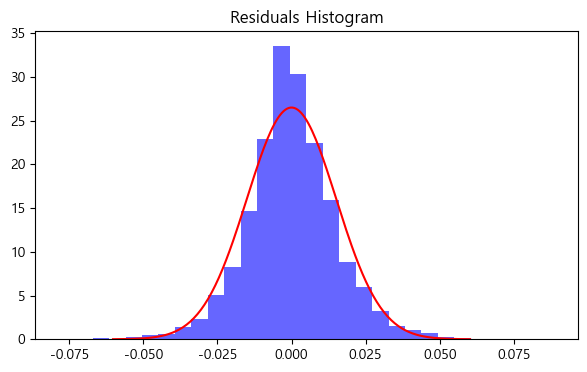

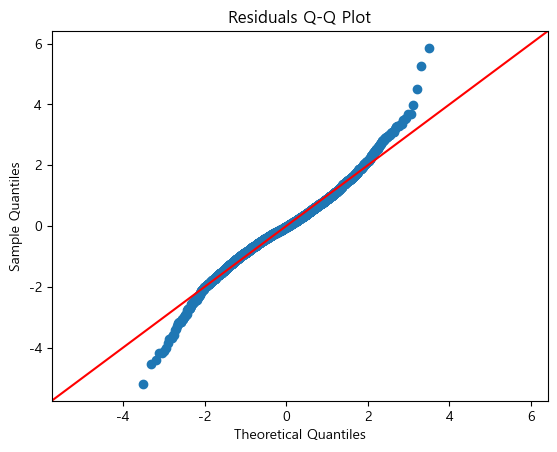

Anderson-Darling p-value: 0.0000


In [24]:
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import PanelOLS

# (패널 회귀 결과: res_fe 가 이미 있다고 가정)
resid = res.resids  # PanelOLS 잔차 (MultiIndex)

# 1. 히스토그램 & Q-Q plot (정규성)
plt.figure(figsize=(7,4))
plt.hist(resid, bins=30, density=True, alpha=0.6, color='blue')
mu, sigma = resid.mean(), resid.std(ddof=0)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
plt.plot(x, st.norm.pdf(x, mu, sigma), color='red')
plt.title('Residuals Histogram')
plt.show()

sm.qqplot(resid, line='45', fit=True)
plt.title('Residuals Q-Q Plot')
plt.show()

# 2. 정규성 검정 (Shapiro-Wilk, Anderson-Darling 등)
from statsmodels.stats.diagnostic import normal_ad
stat, p = normal_ad(resid)
print(f"Anderson-Darling p-value: {p:.4f}")

# 3. 이분산성, 자기상관 -> 검정 생략. Clustered SE 사용했기에 ㄱㅊ.
